# CalMS21 State-Annotation Comparison Analysis

This notebook demonstrates how to compare learned discrete states from SLDS or other models with ground-truth behavioral annotations from the CalMS21 dataset.

## Overview

Since discrete states are learned unsupervised, they don't directly correspond to annotation labels. This analysis:
1. Matches states to annotations using the Hungarian algorithm
2. Computes clustering quality metrics (ARI, NMI, V-measure)
3. Analyzes state purity and coverage
4. Evaluates per-behavior performance
5. Visualizes confusion matrices and correspondences

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0
os.environ["JAX_CAPTURED_CONSTANTS_REPORT_FRAMES"]="-1"
from pathlib import Path
import jax 
jax.config.update("jax_compilation_cache_dir", (Path.cwd() / "tmp/jax_cache").as_posix())
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
try: 
    jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")
except AttributeError:
    pass  # Skip if not available in this JAX version

try:
    import blackjax
except ModuleNotFoundError:
    print('installing blackjax')
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
from natsort import natsorted
# from fastprogress.fastprogress import progress_bar
from functools import partial

# jax.config.update('jax_platform_name', 'cpu')
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count
from flax import nnx

from tqdm.auto import tqdm
# device = 'gpu' if jax.lib.xla_bridge.get_backend().platform == 'gpu' else 'cpu'
device = 'gpu' if jax.extend.backend.get_backend().platform == 'gpu' else 'cpu'
n_gpus = jax.device_count(backend=device)
print(f"Using {n_gpus} device(s) on {device}")

Using 1 device(s) on gpu


✓ Applied TFP compatibility patch for JAX 0.8.0


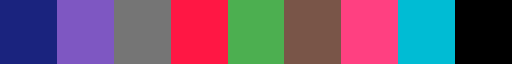

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add TiDHy to path if needed
# sys.path.insert(0, str(Path.cwd()))

# Import TiDHy utilities
from TiDHy.utils.state_annotation_comparison import (
    match_states_to_annotations,
    compute_clustering_metrics,
    compute_state_purity,
    compute_per_behavior_metrics,
    plot_confusion_matrix,
    analyze_state_annotation_correspondence
)
from TiDHy.utils.slds_analysis import load_slds_results
from TiDHy.models.TiDHy_nnx_vmap import TiDHy
from TiDHy.models.TiDHy_nnx_vmap_training import train_model, evaluate_record, load_model, get_latest_checkpoint_epoch, list_checkpoints
from TiDHy.datasets.datasets_dynamax import *
from TiDHy.datasets.load_data import load_data, stack_data
from TiDHy.utils import io_dict_to_hdf5 as ioh5
from TiDHy.utils.path_utils import *

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

%matplotlib inline


##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'ps.fonttype':        42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'sans-serif',
                    #  'font.family':        'Arial',
                    #  'font.sans-serif':    'Arial',
                     'font.serif':         'Arial',
                    })

from matplotlib.colors import ListedColormap
clrs = ['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000']
cmap = ListedColormap(clrs)
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def map_discrete_cbar(cmap,N):
    cmap = plt.get_cmap(cmap,N+1)
    bounds = np.arange(-.5,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53',"#32373B",'#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_b = ListedColormap(clrs_b)
cmap_b


## 1. Load CalMS21 Data with Annotations

In [3]:
dataset = 'CalMS21'
# version = 'HierarchicalMultiTimescale'
version = 'TiDHy'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/TiDHy/{dataset}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 
cfg_num = 1

# NEW APPROACH: Load config and replace paths using workstation.yaml template
cfg = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="workstation",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg_num}, {cfg.dataset.name}: {cfg.version} from {run_cfg_list[cfg_num]}')

# Convert string paths to Path objects and create directories
cfg.paths = convert_dict_to_path(cfg.paths)
print("✅ Successfully converted all paths to Path objects and created directories")


data_dict = load_data(cfg)
inputs_test = data_dict['inputs_test'][None]
max_seq_len = inputs_test.shape[1]

0 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline01/logs/run_config.yaml
1 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline02/logs/run_config.yaml
2 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline/train.feature_type=option_a/logs/run_config.yaml
3 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline/train.feature_type=raw/logs/run_config.yaml
4 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=raw_data01/logs/run_config.yaml
✅ Loaded experiment: 1, CalMS21: TiDHy from /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline02/logs/run_config.yaml
✅ Successfully converted all paths to Path objects and created directories


In [4]:
# Create RNG
rngs = nnx.Rngs(0)

# Get model params as dict and unpack directly
model_params = OmegaConf.to_container(cfg.model, resolve=True)
# model_params.pop('batch_converge')
model_params['input_dim'] = inputs_test.shape[-1]

model = TiDHy(**model_params, rngs=rngs)
# model.l0 = nnx.data(jnp.zeros(3))
# model.loss_weights = nnx.data(jnp.ones(3))
print(f"\nModel initialized successfully!")
print(f"input_dim: {model.input_dim}, r_dim: {model.r_dim}, r2_dim: {model.r2_dim}, mix_dim: {model.mix_dim}")
jit_model = jax.jit(model)
# out = jit_model(inputs_train)
epoch=get_latest_checkpoint_epoch(cfg.paths.ckpt_dir)
loaded_model = load_model(model,cfg.paths.ckpt_dir/f'epoch_{epoch:04d}')


Model initialized successfully!
input_dim: 28, r_dim: 8, r2_dim: 8, mix_dim: 8
Model weights loaded from /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=TiDHy_Baseline02/ckpt/epoch_0925


/home/eabe/miniconda3/envs/tidhy/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:701: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [5]:
result_dict = ioh5.load(cfg.paths.log_dir/'evaluation_results.h5')
seq_len = natsorted(list(result_dict.keys()))
# W = jnp.stack([result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]) for seq in seq_len])
# I = jnp.stack([result_dict[str(seq)]['I'].reshape(-1, result_dict[str(seq)]['I'].shape[-1]) for seq in seq_len])
# Ihat = jnp.stack([result_dict[str(seq)]['I_hat'].reshape(-1, result_dict[str(seq)]['I_hat'].shape[-1]) for seq in seq_len])
# Ibar = jnp.stack([result_dict[str(seq)]['I_bar'].reshape(-1, result_dict[str(seq)]['I_bar'].shape[-1]) for seq in seq_len])
# R_hat = jnp.stack([result_dict[str(seq)]['R_hat'].reshape(-1, result_dict[str(seq)]['R_hat'].shape[-1]) for seq in seq_len])
# R_bar = jnp.stack([result_dict[str(seq)]['R_bar'].reshape(-1, result_dict[str(seq)]['R_bar'].shape[-1]) for seq in seq_len])
# R2_hat = jnp.stack([result_dict[str(seq)]['R2_hat'].reshape(-1, result_dict[str(seq)]['R2_hat'].shape[-1]) for seq in seq_len])
# Ut = jnp.stack([result_dict[str(seq)]['Ut'].reshape((-1,)+ result_dict[str(seq)]['Ut'].shape[2:]) for seq in seq_len])
ts=-1
W = result_dict['{}'.format(seq_len[ts])]['W'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['W'].shape[-1])
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
Ut = result_dict['{}'.format(seq_len[ts])]['Ut'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-2],result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-1])
annotations = data_dict['annotations_test'][:R2_hat.shape[0]]
W.shape, R2_hat.shape, R_hat.shape, Ut.shape,

((262000, 8), (262000, 8), (262000, 8), (262000, 8, 8))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
ts = -1
reg_variables = [np.concatenate([R2_hat,W,R_hat],axis=-1),R2_hat,W,R_hat,R_bar]
labels = ['all','R2_hat','W','R_hat','R_bar']
# reg_variables = [slds_dict['SLDS_latents']]
# labels = ['SLDS_latents']
# reg_variables = [np.concatenate([H,C],axis=-1),H,C,I]
# labels = ['all','H','C','I']

# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):

    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), annotations.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if scores > max_acc:
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred

states = best_pred
behavior_names = list(data_dict['vocabulary'].keys())

all 0.9586106870229008
R2_hat 0.9078931297709923
W 0.5319847328244275
R_hat 0.9585954198473282
R_bar 0.9320763358778626
I 0.9797557251908396


## 2. Load SLDS or Model Results

Load the discrete states from your trained model. This could be from:
- SLDS model results (using `load_slds_results`)
- TiDHy model inference results
- Any other model that produces discrete state sequences

In [ ]:
dataset = 'CalMS21'
# version = 'HierarchicalMultiTimescale'
version = 'SLDS'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/TiDHy/{dataset}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 
cfg_num = 2

# NEW APPROACH: Load config and replace paths using workstation.yaml template
cfg_ssm = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="workstation",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg_num}, {cfg_ssm.dataset.name}: {cfg_ssm.version} from {run_cfg_list[cfg_num]}')

# Convert string paths to Path objects and create directories
cfg_ssm.paths = convert_dict_to_path(cfg_ssm.paths)
print("✅ Successfully converted all paths to Path objects and created directories")

slds_dict = ioh5.load(list(cfg_ssm.paths.log_dir.glob('ssm_slds_*.h5'))[0])
rslds_dict = ioh5.load(list(cfg_ssm.paths.log_dir.glob('ssm_rslds_*.h5'))[0])
emission = rslds_dict['rSLDS_emission']
latents = rslds_dict['rSLDS_latents']
states = rslds_dict['rSLDS_states']
annotations = data_dict['annotations_test']
behavior_names = list(data_dict['vocabulary'].keys())
slds_dict['SLDS_emission'].shape, slds_dict['SLDS_latents'].shape, slds_dict['SLDS_states'].shape

0 CalMS21 SLDS /data2/users/eabe/TiDHy/CalMS21/SLDS/run_id=SLDS_baseline/logs/run_config.yaml
1 CalMS21 SLDS /data2/users/eabe/TiDHy/CalMS21/SLDS/run_id=SSM_Baseline01/train.feature_type=option_a/logs/run_config.yaml
2 CalMS21 SLDS /data2/users/eabe/TiDHy/CalMS21/SLDS/run_id=SSM_Baseline01/train.feature_type=raw/logs/run_config.yaml
3 CalMS21 SLDS /data2/users/eabe/TiDHy/CalMS21/SLDS/run_id=raw_data01/logs/run_config.yaml
✅ Loaded experiment: 2, CalMS21: SLDS from /data2/users/eabe/TiDHy/CalMS21/SLDS/run_id=SSM_Baseline01/train.feature_type=raw/logs/run_config.yaml
✅ Successfully converted all paths to Path objects and created directories


## 3. Quick Data Check

In [14]:
# Uncomment when you have loaded data

print(f"States shape: {states.shape}")
print(f"Annotations shape: {annotations.shape}")
print(f"Number of unique states: {len(np.unique(states))}")
print(f"Number of unique behaviors: {len(np.unique(annotations))}")
print(f"\nBehavior vocabulary: {behavior_names}")
print(f"\nState distribution:")
for s in np.unique(states):
    count = np.sum(states == s)
    print(f"  State {s}: {count} timesteps ({count/len(states)*100:.1f}%)")
print(f"\nAnnotation distribution:")
for a in np.unique(annotations):
    count = np.sum(annotations == a)
    behavior = behavior_names[a] if a < len(behavior_names) else f'Unknown_{a}'
    print(f"  {behavior}: {count} timesteps ({count/len(annotations)*100:.1f}%)")

States shape: (262000,)
Annotations shape: (262000,)
Number of unique states: 4
Number of unique behaviors: 4

Behavior vocabulary: ['attack', 'investigation', 'mount', 'other']

State distribution:
  State 0: 148884 timesteps (56.8%)
  State 1: 67663 timesteps (25.8%)
  State 2: 40057 timesteps (15.3%)
  State 3: 5396 timesteps (2.1%)

Annotation distribution:
  attack: 12630 timesteps (4.8%)
  investigation: 61168 timesteps (23.3%)
  mount: 31848 timesteps (12.2%)
  other: 156354 timesteps (59.7%)


## 4. Comprehensive State-Annotation Analysis

Run the full analysis pipeline using the main analysis function.

In [15]:
# Run comprehensive analysis
# Uncomment when data is loaded

results = analyze_state_annotation_correspondence(
    states=states,
    annotations=annotations,
    behavior_names=behavior_names,
    verbose=True
)

print("This will print a comprehensive analysis summary including:")
print("  - Data summary (timesteps, num states, num behaviors)")
print("  - Clustering quality metrics (ARI, NMI, V-measure, accuracy)")
print("  - Purity metrics (state purity, annotation purity)")
print("  - Per-behavior performance (precision, recall, F1)")

State-Annotation Correspondence Analysis

Data Summary:
  Total timesteps: 262000
  Number of learned states: 4
  Number of annotation behaviors: 4

Clustering Quality Metrics:
  Adjusted Rand Index: 0.042
  Normalized Mutual Info: 0.063
  V-measure: 0.063
  Accuracy (after matching): 0.447
  Matched fraction: 1.000

Purity Metrics:
  State purity: 0.606
  Annotation purity (inverse): 0.583

Per-Behavior Performance (Macro-averaged):
  Precision: 0.414
  Recall: 0.333
  F1-score: 0.354

Per-Behavior Breakdown:
  attack:
    Precision: 0.639
    Recall: 0.273
    F1: 0.382
    Support: 12630
  investigation:
    Precision: 0.239
    Recall: 0.264
    F1: 0.251
    Support: 61168
  mount:
    Precision: 0.171
    Recall: 0.215
    F1: 0.191
    Support: 31848
  other:
    Precision: 0.608
    Recall: 0.579
    F1: 0.593
    Support: 156354
This will print a comprehensive analysis summary including:
  - Data summary (timesteps, num states, num behaviors)
  - Clustering quality metrics (AR

## 5. Visualize Confusion Matrix

Show which learned states correspond to which behavioral annotations.

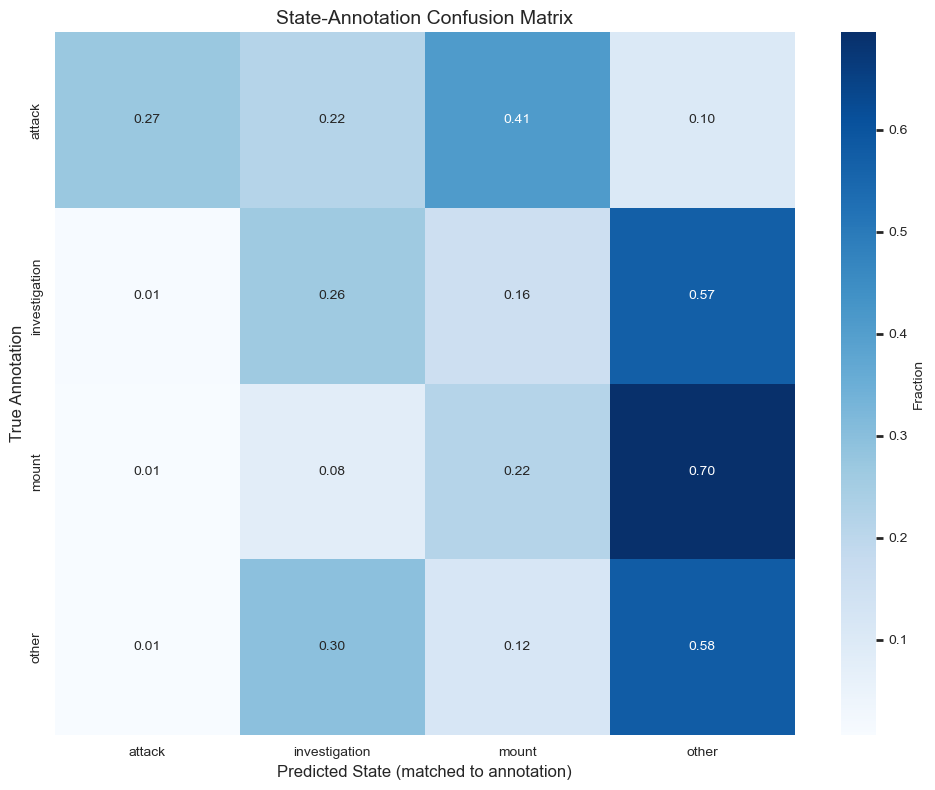

Confusion matrix will show:
  - Rows: True behavioral annotations
  - Columns: Learned states (matched to annotations)
  - Diagonal: Perfect correspondence
  - Off-diagonal: Mismatches/confusions


In [16]:
# Uncomment when data is loaded

matched_states = results['matching']['matched_states']

fig = plot_confusion_matrix(
    matched_states=matched_states,
    annotations=annotations,
    behavior_names=behavior_names,
    normalize='true',  # Row-normalize (shows recall)
    figsize=(10, 8)
)
plt.show()

print("Confusion matrix will show:")
print("  - Rows: True behavioral annotations")
print("  - Columns: Learned states (matched to annotations)")
print("  - Diagonal: Perfect correspondence")
print("  - Off-diagonal: Mismatches/confusions")

## 6. Analyze State-to-Annotation Matching

Examine which states were matched to which annotations.

In [17]:
# Uncomment when data is loaded

state_to_annotation = results['matching']['state_to_annotation']
contingency = results['matching']['contingency']

print("State-to-Annotation Matching:")
print("="*50)
for state_idx, annot_idx in state_to_annotation.items():
    behavior = behavior_names[annot_idx] if annot_idx < len(behavior_names) else f'Unknown_{annot_idx}'
    overlap = contingency[state_idx, annot_idx]
    state_total = contingency[state_idx].sum()
    purity = overlap / state_total if state_total > 0 else 0
    print(f"State {state_idx} -> {behavior}")
    print(f"  Overlap: {overlap} / {state_total} timesteps ({purity*100:.1f}% pure)")

print("This will show how each learned state maps to behavioral annotations")

State-to-Annotation Matching:
State 0 -> other
  Overlap: 90560 / 148884 timesteps (60.8% pure)
State 1 -> investigation
  Overlap: 16154 / 67663 timesteps (23.9% pure)
State 2 -> mount
  Overlap: 6860 / 40057 timesteps (17.1% pure)
State 3 -> attack
  Overlap: 3446 / 5396 timesteps (63.9% pure)
This will show how each learned state maps to behavioral annotations


## 7. Detailed Per-Behavior Performance

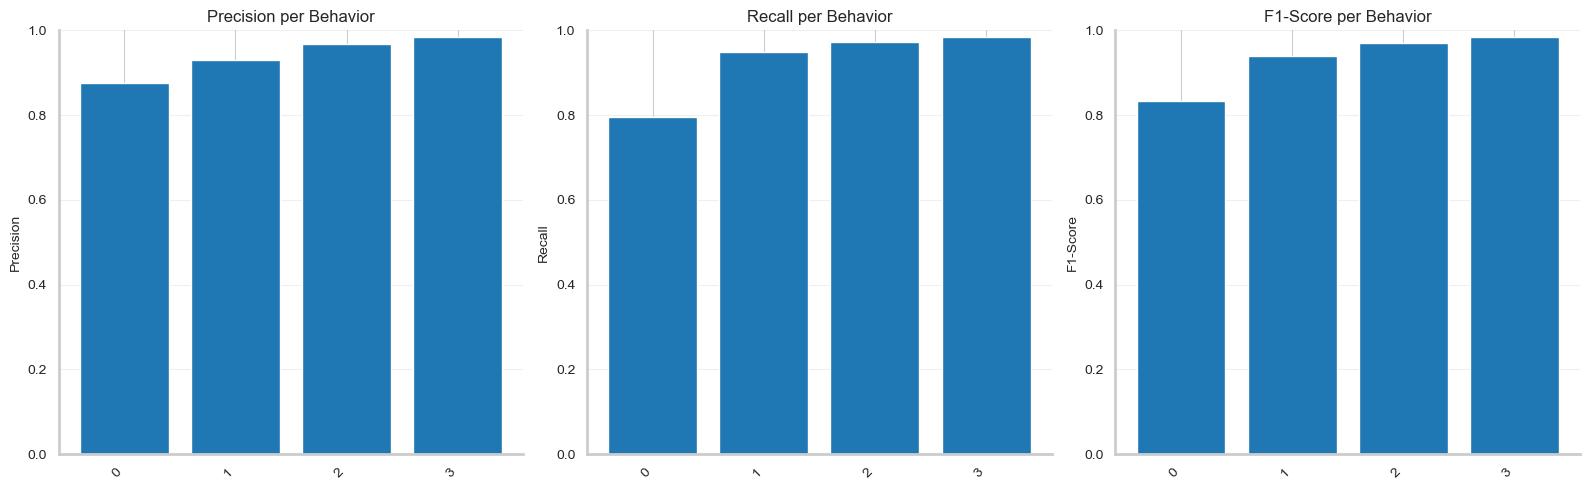

This will create bar plots showing precision, recall, and F1-score for each behavior


In [35]:
# Uncomment when data is loaded

per_behavior = results['per_behavior_metrics']

# Create bar plot of F1 scores per behavior
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

behaviors = behavior_names[:len(per_behavior['per_behavior_f1'])]
x = np.arange(len(behaviors))

# Precision
axes[0].bar(x, per_behavior['per_behavior_precision'])
axes[0].set_xticks(x)
axes[0].set_xticklabels(behaviors, rotation=45, ha='right')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision per Behavior')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Recall
axes[1].bar(x, per_behavior['per_behavior_recall'])
axes[1].set_xticks(x)
axes[1].set_xticklabels(behaviors, rotation=45, ha='right')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall per Behavior')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# F1-score
axes[2].bar(x, per_behavior['per_behavior_f1'])
axes[2].set_xticks(x)
axes[2].set_xticklabels(behaviors, rotation=45, ha='right')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score per Behavior')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("This will create bar plots showing precision, recall, and F1-score for each behavior")

## 8. State Purity Analysis

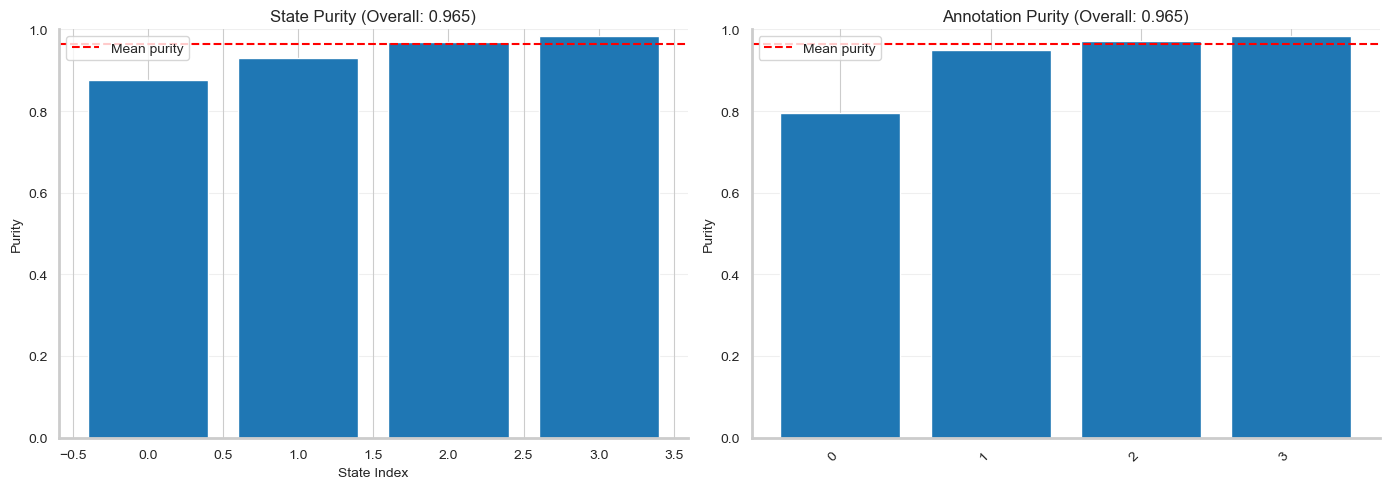

Purity analysis will show:
  - State purity: How 'pure' each state is (maps to one behavior)
  - Annotation purity: How well each behavior is captured by one state


In [36]:
# Uncomment when data is loaded

purity = results['purity_metrics']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-state purity
num_states = len(purity['per_state_purity'])
axes[0].bar(range(num_states), purity['per_state_purity'])
axes[0].set_xlabel('State Index')
axes[0].set_ylabel('Purity')
axes[0].set_title(f"State Purity (Overall: {purity['purity']:.3f})")
axes[0].set_ylim([0, 1])
axes[0].axhline(purity['purity'], color='r', linestyle='--', label='Mean purity')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Per-annotation purity (inverse purity)
num_annot = len(purity['per_annotation_purity'])
behaviors = behavior_names[:num_annot]
axes[1].bar(range(num_annot), purity['per_annotation_purity'])
axes[1].set_xticks(range(num_annot))
axes[1].set_xticklabels(behaviors, rotation=45, ha='right')
axes[1].set_ylabel('Purity')
axes[1].set_title(f"Annotation Purity (Overall: {purity['inverse_purity']:.3f})")
axes[1].set_ylim([0, 1])
axes[1].axhline(purity['inverse_purity'], color='r', linestyle='--', label='Mean purity')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Purity analysis will show:")
print("  - State purity: How 'pure' each state is (maps to one behavior)")
print("  - Annotation purity: How well each behavior is captured by one state")

## 9. Visualize State and Annotation Time Series

Compare the temporal structure of learned states vs. annotations.

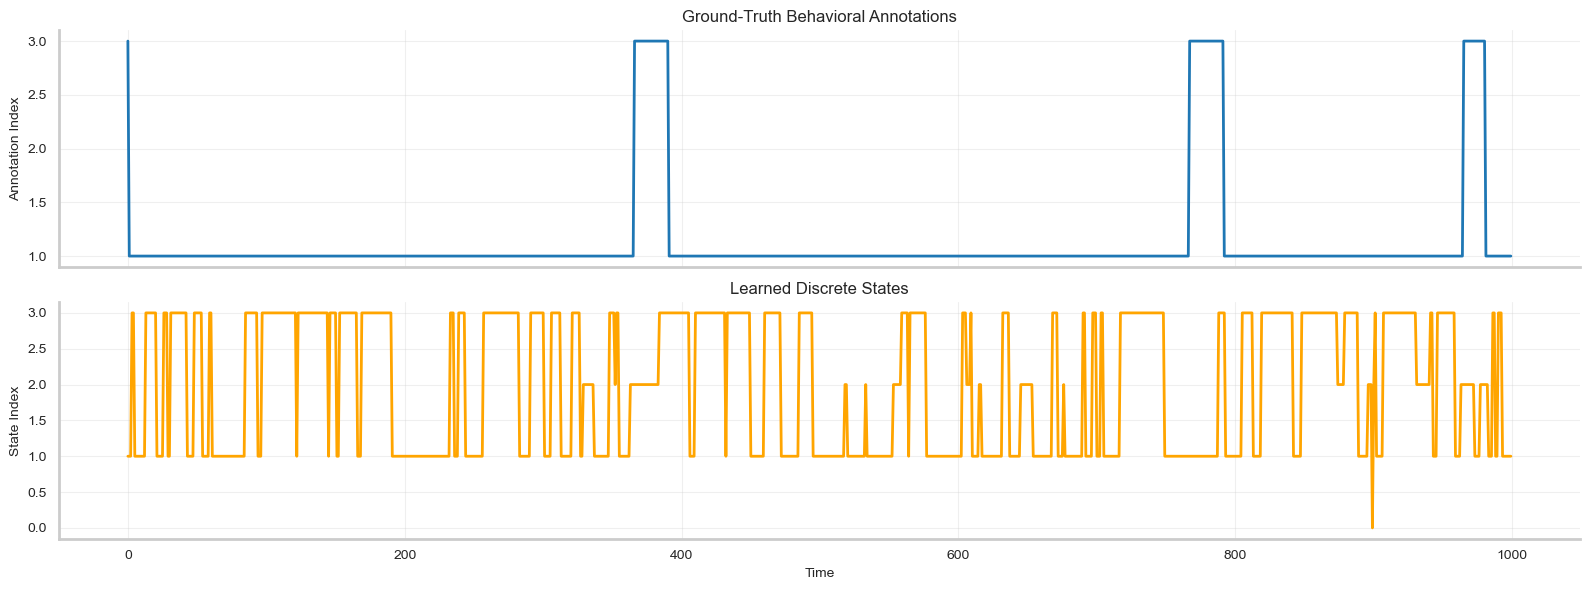

This will show time series comparison of annotations vs. learned states


In [12]:
# Uncomment when data is loaded

# # Plot a window of time
t_start = 0
t_end = 1000  # Adjust as needed

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

# Annotations
axes[0].plot(annotations[t_start:t_end], linewidth=2)
axes[0].set_ylabel('Annotation Index')
axes[0].set_title('Ground-Truth Behavioral Annotations')
axes[0].grid(alpha=0.3)

# Learned states
axes[1].plot(states[t_start:t_end], linewidth=2, color='orange')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('State Index')
axes[1].set_title('Learned Discrete States')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("This will show time series comparison of annotations vs. learned states")

## 10. Export Results

Save analysis results for later use.

In [ ]:
# Uncomment to save results

# import pickle

# output_path = Path('state_annotation_analysis_results.pkl')
# with open(output_path, 'wb') as f:
#     pickle.dump(results, f)

# print(f"Results saved to {output_path}")

# # Or save as JSON (requires converting numpy arrays)
# import json

# def convert_to_json_serializable(obj):
#     """Convert numpy arrays to lists for JSON serialization."""
#     if isinstance(obj, np.ndarray):
#         return obj.tolist()
#     elif isinstance(obj, dict):
#         return {k: convert_to_json_serializable(v) for k, v in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_to_json_serializable(v) for v in obj]
#     else:
#         return obj

# # Save metrics only (not full arrays)
# metrics_summary = {
#     'clustering_metrics': results['clustering_metrics'],
#     'purity_metrics': {
#         'purity': results['purity_metrics']['purity'],
#         'inverse_purity': results['purity_metrics']['inverse_purity'],
#     },
#     'per_behavior_metrics': {
#         'macro_avg_precision': results['per_behavior_metrics']['macro_avg_precision'],
#         'macro_avg_recall': results['per_behavior_metrics']['macro_avg_recall'],
#         'macro_avg_f1': results['per_behavior_metrics']['macro_avg_f1'],
#     }
# }

# json_path = Path('state_annotation_metrics.json')
# with open(json_path, 'w') as f:
#     json.dump(convert_to_json_serializable(metrics_summary), f, indent=2)

# print(f"Metrics summary saved to {json_path}")

print("Save results as pickle or JSON for later analysis")

## Summary

This notebook provides a complete workflow for analyzing the correspondence between learned discrete states and ground-truth behavioral annotations. Key takeaways:

1. **Matching**: Hungarian algorithm optimally aligns states to annotations
2. **Clustering Metrics**: ARI, NMI, and V-measure quantify overall quality
3. **Purity**: Measures how well states capture single behaviors
4. **Per-Behavior**: Precision, recall, and F1 show performance per behavior
5. **Visualization**: Confusion matrices and time series reveal structure

Use these analyses to:
- Validate that learned states capture meaningful behavioral structure
- Compare different models or hyperparameters
- Interpret what each discrete state represents
- Identify which behaviors are well-captured vs. challenging